#### By: Peyman Shahidi
#### Created: Oct 9, 2025

<br>

In [74]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [75]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [76]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [77]:
# Read O*NET data
onet = pd.read_csv(f'{input_data_path}/onet_occupations_yearly.csv')

# keep 2023 entries only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# define industry column:
# 2-digit SOC code --> Major Group
# 5-digit SOC code --> Minor Group
# 6-digit SOC code --> Broad Occupation
# 7-digit SOC code --> Detailed Occupation
SOC_group_num_digits = 5
onet['ind'] = onet['occ_code'].apply(lambda x: x[:SOC_group_num_digits])

# remove 's for consistency issues 
onet = onet.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

In [78]:
def merge_SOC_titles(df, occupation_string):
    # Assume column occupation_string contains the string of occupation identifier in df

    occLength_SOCcolumn_mapping = {
        2: 'Major Group',
        5: 'Minor Group',
        6: 'Broad Occupation',
        7: 'Detailed Occupation'
    }

    industry_column_entry_length = len(df[occupation_string].iloc[0]) # take the length of first entry
    soc_col_name = occLength_SOCcolumn_mapping[industry_column_entry_length]

    # Read SOC groups and derive 2 digit codes (from https://www.onetcenter.org/taxonomy/2019/structure.html)
    soc_group_df = pd.read_csv(f'{input_data_path}/SOC_Structure.csv')
    soc_group_df = soc_group_df[[soc_col_name, 'SOC or O*NET-SOC 2019 Title']]
    soc_group_df = soc_group_df.rename(columns={soc_col_name: 'ind',
                                                'SOC or O*NET-SOC 2019 Title': 'ind_name'
                                                })

    # Prepare dataset for the merge
    soc_group_df = soc_group_df.dropna() # Drop rows with NaN in 'ind' or 'ind_name' -- has to be included due to structure of "SOC_Structure.csv"
    soc_group_df['ind'] = soc_group_df['ind'].apply(lambda x: x[:industry_column_entry_length])

    # Merge datasets
    merged_df = pd.merge(df, soc_group_df, left_on=occupation_string, right_on='ind', how='left')

    return merged_df

# Merge O*NET data with SOC titles
onet = merge_SOC_titles(onet, 'ind')

In [79]:
# Load GPTs are GPTs exposure measures
gpts_df = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/occ_level.csv')

# Which measure do you want?
# E1: alpha
# E1 + 0.5 E2: beta
# E1 + E2 = gamma
my_measure = 'gamma'
gpts_df = gpts_df.rename(columns={
    'O*NET-SOC Code': 'occ_code',
    'Title': 'occ_title',
    f'dv_rating_{my_measure}': 'gpt4_score',
    f'human_rating_{my_measure}': 'human_score'
})
gpts_df = gpts_df[['occ_code', 'occ_title', 'gpt4_score', 'human_score']]


# Keep only codes ending in '00' and remove the '.00' suffix
gpts_df = gpts_df[gpts_df['occ_code'].astype(str).str.endswith('00')].copy()
gpts_df['occ_code'] = gpts_df['occ_code'].astype(str).str.replace(r'\.00$', '', regex=True)
gpts_df

,occ_code,occ_title,gpt4_score,human_score
0,11-1011,Chief Executives,0.82,0.52
2,11-1021,General and Operations Managers,0.96,0.65
3,11-1031,Legislators,0.77,0.77
4,11-2011,Advertising and Promotions Managers,0.95,0.84
5,11-2021,Marketing Managers,0.94,0.94
...,...,...,...,...
918,53-7071,Gas Compressor and Gas Pumping Station Operators,0.31,0.15
919,53-7072,"Pump Operators, Except Wellhead Pumpers",0.33,0.33
920,53-7073,Wellhead Pumpers,0.00,0.00
921,53-7081,Refuse and Recyclable Material Collectors,0.21,0.36


In [80]:
## Merge AI Exposure to O*NET dataset
onet = pd.merge(onet, gpts_df, on=['occ_code', 'occ_title'], how='left')

# Filter out rows with NaN GPT and human scores
onet_with_scores = onet.dropna(subset=['gpt4_score', 'human_score'])
onet

,year,occ_code,occ_title,task_id,task,task_type,wa_id,wa_name,dwa_id,dwa_title,...,daily,several_times_daily,hourly_or_more,task_importance,task_relevance,wa_importance,ind,ind_name,gpt4_score,human_score
0,2023,11-1011,Chief Executives,8833,"Preside over, or serve on, boards of directors...",Core,NaN,NaN,NaN,NaN,...,4.28,3.02,0.00,3.96,72.72,NaN,11-10,Top Executives,0.82,0.52
1,2023,11-1011,Chief Executives,8835,Establish departmental responsibilities and co...,Core,NaN,NaN,NaN,NaN,...,14.05,5.55,0.00,3.96,84.86,NaN,11-10,Top Executives,0.82,0.52
2,2023,11-1011,Chief Executives,8842,Nominate citizens to boards or commissions.,Supplemental,NaN,NaN,NaN,NaN,...,4.48,0.00,0.00,2.81,26.95,NaN,11-10,Top Executives,0.82,0.52
3,2023,11-1011,Chief Executives,8845,Refer major policy matters to elected represen...,Supplemental,NaN,NaN,NaN,NaN,...,0.00,2.60,0.00,3.92,46.48,NaN,11-10,Top Executives,0.82,0.52
4,2023,11-1011,Chief Executives,8848,Direct or conduct studies or research on issue...,Core,NaN,NaN,NaN,NaN,...,4.58,0.20,0.79,3.33,75.11,NaN,11-10,Top Executives,0.82,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24421,2023,53-3033,Light Truck Drivers,8624,"Report delays, accidents, or other traffic and...",Supplemental,4.A.4.a.2,"Communicating with Supervisors, Peers, or Subo...",4.A.4.a.2.I08.D07,"Notify others of emergencies, problems, or haz...",...,42.95,0.00,15.88,3.73,53.14,4.21,53-30,Motor Vehicle Operators,0.50,0.50
24422,2023,53-3033,Light Truck Drivers,8621,Turn in receipts and money received from deliv...,Supplemental,4.A.4.c.1,Performing Administrative Activities,4.A.4.c.1.I03.D06,Process customer bills or payments.,...,48.85,5.67,12.97,4.67,66.77,2.09,53-30,Motor Vehicle Operators,0.50,0.50
24423,2023,53-5022,Motorboat Operators,14546,"Tow, push, or guide other boats, barges, logs,...",Supplemental,4.A.3.a.4,"Operating Vehicles, Mechanized Devices, or Equ...",4.A.3.a.4.I01.D01,Operate ships or other watercraft.,...,14.34,0.00,26.73,3.88,60.10,4.58,53-50,Water Transportation Workers,0.00,0.26
24424,2023,53-7081,Refuse and Recyclable Material Collectors,7180,Tag garbage or recycling containers to inform ...,Supplemental,4.A.4.a.1,Interpreting the Meaning of Information for Ot...,4.A.4.a.1.I02.D04,"Explain regulations, policies, or procedures.",...,45.36,11.68,10.17,3.79,58.93,1.36,53-70,Material Moving Workers,0.21,0.36


In [81]:
# remove duplicates
print(f"Number of rows before removing duplicates: {len(onet)}")
onet = onet.drop_duplicates(subset=['year', 'ind', 'occ_code', 'task_id']).reset_index(drop=True)
print(f"Number of rows after removing duplicates: {len(onet)}")


############################################################################################
################## There's a lot of duplicates that you have to look into ##################
############################################################################################

Number of rows before removing duplicates: 24426
Number of rows after removing duplicates: 19294


In [82]:
# # Remove rows where occupation title contains "All Other"
# onet = onet[~onet["occ_title"].str.contains("All Other", case=False, na=False)]

### Remove "Teachers"-related occupations

In [83]:
# Filter rows that contain "Teachers" (case-insensitive)
contains_teacher = onet[onet['occ_title'].str.contains('Teachers', case=False, na=False)]

# Step 2: Get the number of unique occupations containing "Teacher"
unique_teacher_occupations = contains_teacher['occ_title'].nunique()
print(f'Number of unique occupations containing the word "Teachers": {unique_teacher_occupations}')

# Remove rows that contain "Teacher" (case-insensitive)
onet = onet[~onet['occ_title'].str.contains('Teachers', case=False, na=False)].reset_index(drop=True)

Number of unique occupations containing the word "Teachers": 50


### Number of Unique Tasks / DWAs / WAs

In [84]:
# Number of unique tasks, DWAs, and WAs
num_unique_tasks = onet['task_id'].nunique()
num_unique_dwas = onet['dwa_id'].nunique()
num_unique_was = onet['wa_id'].nunique()

print(f"Number of unique tasks: {num_unique_tasks}")
print(f"Number of unique DWAs: {num_unique_dwas}")
print(f"Number of unique WAs: {num_unique_was}")

Number of unique tasks: 17945
Number of unique DWAs: 2067
Number of unique WAs: 37


### Plot Number of Tasks/DWAs Against Exposure

In [85]:
# Create aggregated dataset with unique tasks/DWAs per occupation and exposure measures

occ_summary = (
    onet_with_scores.groupby(['occ_code', 'occ_title', 'ind_name'])
    .agg(
        num_unique_tasks=('task', 'nunique'),
        num_unique_dwas=('dwa_title', 'nunique'),
        num_unique_was=('wa_name', 'nunique'),
        gpt4_score=('gpt4_score', 'first'),  # These should be the same for each occupation
        human_score=('human_score', 'first')
    )
    .reset_index()
)

print(f"Number of occupations in summary dataset: {len(occ_summary)}")
print(f"Number of occupations with GPT4 scores: {occ_summary['gpt4_score'].notna().sum()}")
print(f"Number of occupations with human scores: {occ_summary['human_score'].notna().sum()}")

# Display sample of the data
print("\nSample of occupation summary data:")
occ_summary

Number of occupations in summary dataset: 646
Number of occupations with GPT4 scores: 646
Number of occupations with human scores: 646

Sample of occupation summary data:


,occ_code,occ_title,ind_name,num_unique_tasks,num_unique_dwas,num_unique_was,gpt4_score,human_score
0,11-1011,Chief Executives,Top Executives,49,54,19,0.82,0.52
1,11-1021,General and Operations Managers,Top Executives,17,20,10,0.96,0.65
2,11-1031,Legislators,Top Executives,30,23,18,0.77,0.77
3,11-2011,Advertising and Promotions Managers,"Advertising, Marketing, Promotions, Public Rel...",30,33,17,0.95,0.84
4,11-2021,Marketing Managers,"Advertising, Marketing, Promotions, Public Rel...",20,19,12,0.94,0.94
...,...,...,...,...,...,...,...,...
641,53-7065,Stockers and Order Fillers,Material Moving Workers,30,26,12,0.25,0.27
642,53-7071,Gas Compressor and Gas Pumping Station Operators,Material Moving Workers,13,9,7,0.31,0.15
643,53-7072,"Pump Operators, Except Wellhead Pumpers",Material Moving Workers,14,18,11,0.33,0.33
644,53-7073,Wellhead Pumpers,Material Moving Workers,16,15,9,0.00,0.00


Number of occupations with complete exposure scores: 646


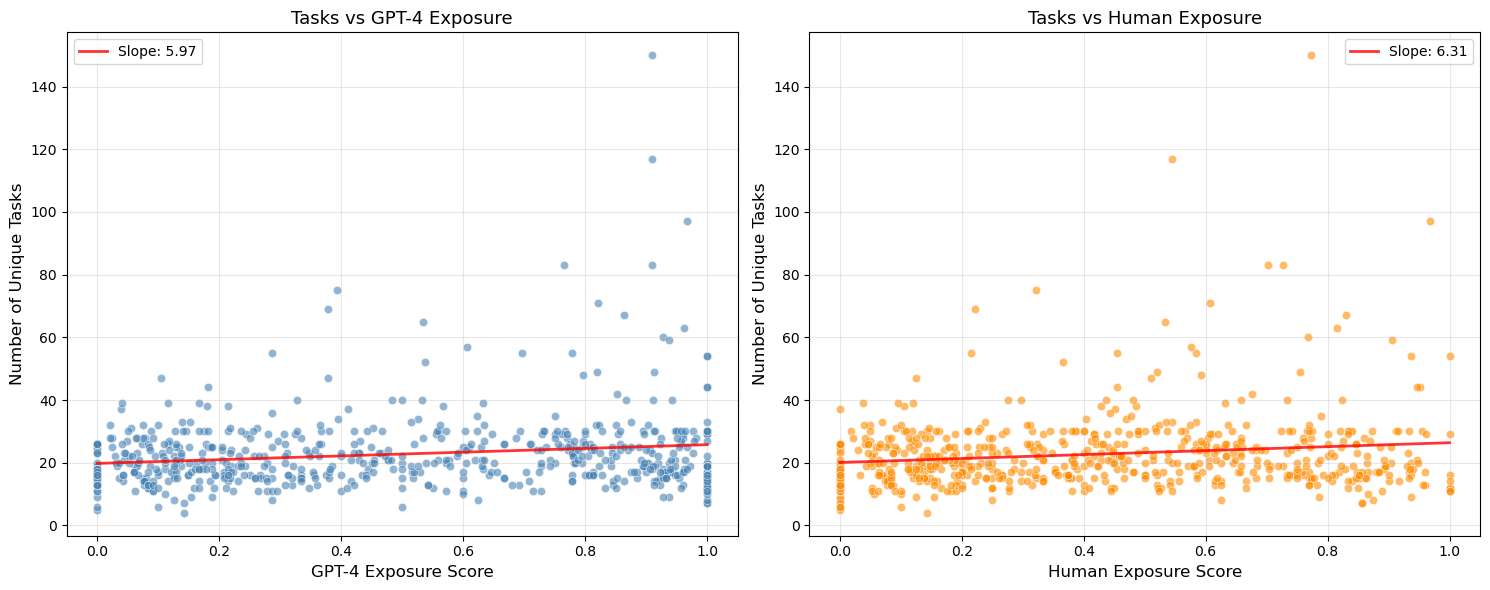

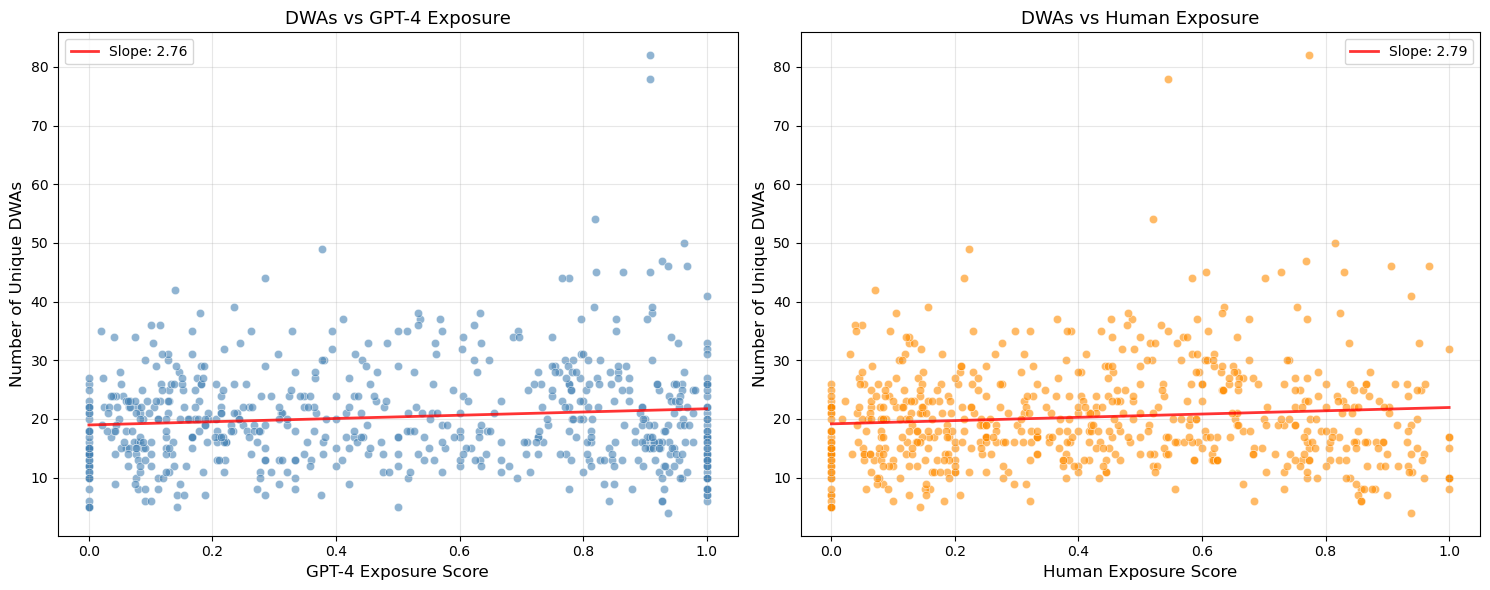

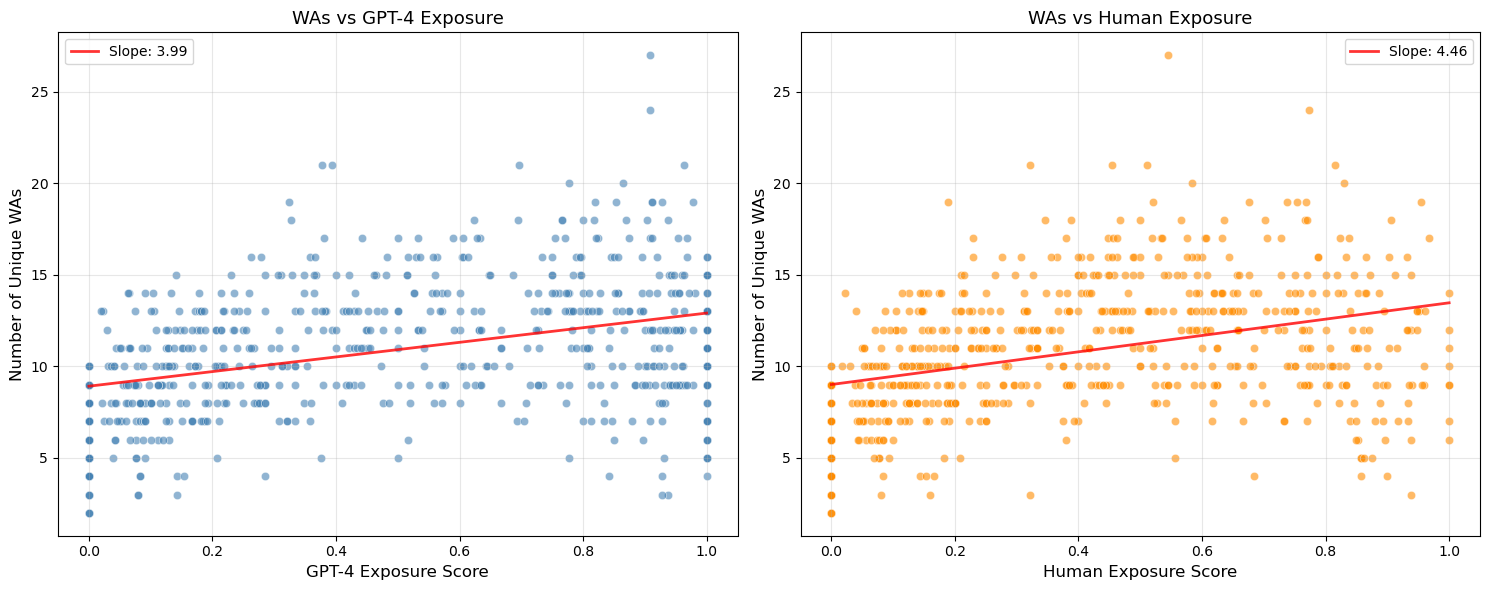

Plotted data for 646 occupations with complete exposure scores


In [86]:
# Filter data to only include occupations with exposure scores
occ_with_scores = occ_summary.dropna(subset=['gpt4_score', 'human_score'])

print(f"Number of occupations with complete exposure scores: {len(occ_with_scores)}")

# Figure 1: Number of Unique Tasks vs Exposure Scores
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Tasks vs GPT4 score
ax1.scatter(occ_with_scores['gpt4_score'], occ_with_scores['num_unique_tasks'], 
           alpha=0.6, color='steelblue', edgecolors='white', linewidth=0.5)

# Fit and plot line for Tasks vs GPT4
x1 = occ_with_scores['gpt4_score'].values
y1 = occ_with_scores['num_unique_tasks'].values
slope1, intercept1 = np.polyfit(x1, y1, 1)
x1_fit = np.linspace(x1.min(), x1.max(), 100)
y1_fit = slope1 * x1_fit + intercept1
ax1.plot(x1_fit, y1_fit, color='red', linewidth=2, alpha=0.8, label=f'Slope: {slope1:.2f}')

ax1.set_xlabel('GPT-4 Exposure Score', fontsize=12)
ax1.set_ylabel('Number of Unique Tasks', fontsize=12)
ax1.set_title('Tasks vs GPT-4 Exposure', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot: Tasks vs Human score
ax2.scatter(occ_with_scores['human_score'], occ_with_scores['num_unique_tasks'], 
           alpha=0.6, color='darkorange', edgecolors='white', linewidth=0.5)

# Fit and plot line for Tasks vs Human
x2 = occ_with_scores['human_score'].values
y2 = occ_with_scores['num_unique_tasks'].values
slope2, intercept2 = np.polyfit(x2, y2, 1)
x2_fit = np.linspace(x2.min(), x2.max(), 100)
y2_fit = slope2 * x2_fit + intercept2
ax2.plot(x2_fit, y2_fit, color='red', linewidth=2, alpha=0.8, label=f'Slope: {slope2:.2f}')

ax2.set_xlabel('Human Exposure Score', fontsize=12)
ax2.set_ylabel('Number of Unique Tasks', fontsize=12)
ax2.set_title('Tasks vs Human Exposure', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(f'{output_plot_path}/tasks_vs_exposure_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Number of Unique DWAs vs Exposure Scores
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: DWAs vs GPT4 score
ax3.scatter(occ_with_scores['gpt4_score'], occ_with_scores['num_unique_dwas'], 
           alpha=0.6, color='steelblue', edgecolors='white', linewidth=0.5)

# Fit and plot line for DWAs vs GPT4
x3 = occ_with_scores['gpt4_score'].values
y3 = occ_with_scores['num_unique_dwas'].values
slope3, intercept3 = np.polyfit(x3, y3, 1)
x3_fit = np.linspace(x3.min(), x3.max(), 100)
y3_fit = slope3 * x3_fit + intercept3
ax3.plot(x3_fit, y3_fit, color='red', linewidth=2, alpha=0.8, label=f'Slope: {slope3:.2f}')

ax3.set_xlabel('GPT-4 Exposure Score', fontsize=12)
ax3.set_ylabel('Number of Unique DWAs', fontsize=12)
ax3.set_title('DWAs vs GPT-4 Exposure', fontsize=13)
ax3.grid(True, alpha=0.3)
ax3.legend()

# Right plot: DWAs vs Human score
ax4.scatter(occ_with_scores['human_score'], occ_with_scores['num_unique_dwas'], 
           alpha=0.6, color='darkorange', edgecolors='white', linewidth=0.5)

# Fit and plot line for DWAs vs Human
x4 = occ_with_scores['human_score'].values
y4 = occ_with_scores['num_unique_dwas'].values
slope4, intercept4 = np.polyfit(x4, y4, 1)
x4_fit = np.linspace(x4.min(), x4.max(), 100)
y4_fit = slope4 * x4_fit + intercept4
ax4.plot(x4_fit, y4_fit, color='red', linewidth=2, alpha=0.8, label=f'Slope: {slope4:.2f}')

ax4.set_xlabel('Human Exposure Score', fontsize=12)
ax4.set_ylabel('Number of Unique DWAs', fontsize=12)
ax4.set_title('DWAs vs Human Exposure', fontsize=13)
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.savefig(f'{output_plot_path}/dwas_vs_exposure_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: Number of Unique WAs vs Exposure Scores
fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: WAs vs GPT4 score
ax5.scatter(occ_with_scores['gpt4_score'], occ_with_scores['num_unique_was'], 
           alpha=0.6, color='steelblue', edgecolors='white', linewidth=0.5)

# Fit and plot line for WAs vs GPT4
x5 = occ_with_scores['gpt4_score'].values
y5 = occ_with_scores['num_unique_was'].values
slope5, intercept5 = np.polyfit(x5, y5, 1)
x5_fit = np.linspace(x5.min(), x5.max(), 100)
y5_fit = slope5 * x5_fit + intercept5
ax5.plot(x5_fit, y5_fit, color='red', linewidth=2, alpha=0.8, label=f'Slope: {slope5:.2f}')

ax5.set_xlabel('GPT-4 Exposure Score', fontsize=12)
ax5.set_ylabel('Number of Unique WAs', fontsize=12)
ax5.set_title('WAs vs GPT-4 Exposure', fontsize=13)
ax5.grid(True, alpha=0.3)
ax5.legend()

# Right plot: WAs vs Human score
ax6.scatter(occ_with_scores['human_score'], occ_with_scores['num_unique_was'], 
           alpha=0.6, color='darkorange', edgecolors='white', linewidth=0.5)

# Fit and plot line for WAs vs Human
x6 = occ_with_scores['human_score'].values
y6 = occ_with_scores['num_unique_was'].values
slope6, intercept6 = np.polyfit(x6, y6, 1)
x6_fit = np.linspace(x6.min(), x6.max(), 100)
y6_fit = slope6 * x6_fit + intercept6
ax6.plot(x6_fit, y6_fit, color='red', linewidth=2, alpha=0.8, label=f'Slope: {slope6:.2f}')

ax6.set_xlabel('Human Exposure Score', fontsize=12)
ax6.set_ylabel('Number of Unique WAs', fontsize=12)
ax6.set_title('WAs vs Human Exposure', fontsize=13)
ax6.grid(True, alpha=0.3)
ax6.legend()

plt.tight_layout()
plt.savefig(f'{output_plot_path}/was_vs_exposure_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plotted data for {len(occ_with_scores)} occupations with complete exposure scores")

In [87]:
occ_summary[occ_summary.occ_title == 'Travel Agents']


,occ_code,occ_title,ind_name,num_unique_tasks,num_unique_dwas,num_unique_was,gpt4_score,human_score
366,41-3041,Travel Agents,"Sales Representatives, Services",8,8,5,1.00,0.88


In [89]:
import pandas as pd

df = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")
# Drop the first two columns
df = df.drop(df.columns[:1], axis=1)
df.head(50)

,O*NET-SOC Code,Task ID,Task,Task Type,Title,human_exposure_agg,gpt4_exposure,gpt4_exposure_alt_rubric,gpt_3_relevant,gpt4_automation,alpha,beta,gamma,automation,human_labels
0,11-1011.00,"8,823.00",Direct or coordinate an organization's financi...,Core,Chief Executives,E0,E2,E2,False,T2,0.00,0.50,1.00,0.50,E0
1,11-1011.00,"8,831.00",Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0
2,11-1011.00,"8,825.00",Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
3,11-1011.00,"8,826.00","Direct, plan, or implement policies, objective...",Core,Chief Executives,E0,E2,E0,False,T1,0.00,0.50,1.00,0.25,E0
4,11-1011.00,"8,827.00","Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
5,11-1011.00,"8,824.00","Confer with board members, organization offici...",Core,Chief Executives,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0
6,11-1011.00,"8,836.00",Implement corrective action plans to solve org...,Core,Chief Executives,E1,E2,E2,False,T1,0.00,0.50,1.00,0.25,E1
7,11-1011.00,"8,832.00","Direct human resources activities, including t...",Core,Chief Executives,E2,E2,E0,False,T1,0.00,0.50,1.00,0.25,E2
8,11-1011.00,"8,835.00",Establish departmental responsibilities and co...,Core,Chief Executives,E0,E2,E2,False,T1,0.00,0.50,1.00,0.25,E0
9,11-1011.00,"8,833.00","Preside over, or serve on, boards of directors...",Core,Chief Executives,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0


In [90]:
def compute_exposure_shares(df, exposure_col, prefix):
    # Weight core vs. supplemental tasks (if column exists)
    df["task_weight"] = df["Task Type"].map({"Core": 1.0, "Supplemental": 0.5}).fillna(1.0)

    # One-hot exposure indicators
    df[f"{prefix}_E1"] = (df[exposure_col] == "E1").astype(int)
    df[f"{prefix}_E2"] = (df[exposure_col] == "E2").astype(int)

    # Weighted shares per occupation
    occ_level = (
        df.groupby(["O*NET-SOC Code", "Title"])
        .apply(lambda x: pd.Series({
            f"{prefix}_E1_share": (x[f"{prefix}_E1"] * x["task_weight"]).sum() / x["task_weight"].sum(),
            f"{prefix}_E2_share": (x[f"{prefix}_E2"] * x["task_weight"]).sum() / x["task_weight"].sum(),
        }))
        .reset_index()
    )

    # Composite measures
    occ_level[f"{prefix}_E1_plus_halfE2"] = occ_level[f"{prefix}_E1_share"] + 0.5 * occ_level[f"{prefix}_E2_share"]
    occ_level[f"{prefix}_E1_plus_E2"]     = occ_level[f"{prefix}_E1_share"] + occ_level[f"{prefix}_E2_share"]

    occ_level = occ_level.drop(columns=[f'{prefix}_E2_share'])

    occ_level = occ_level.rename(columns={'gpt4_E1_share': 'gpt4_alpha',
                                          'gpt4_E1_plus_halfE2': 'gpt4_beta',
                                          'gpt4_E1_plus_E2': 'gpt4_gamma',
                                          'human_E1_share': 'human_alpha',
                                          'human_E1_plus_halfE2': 'human_beta',
                                          'human_E1_plus_E2': 'human_gamma'})

    return occ_level

gpt_occ_level = compute_exposure_shares(df, "gpt4_exposure", "gpt4")
human_occ_level = compute_exposure_shares(df, "human_labels", "human")

# Merge results on occupation code and title
occ_level = pd.merge(gpt_occ_level, human_occ_level, on=["O*NET-SOC Code", "Title"])
occ_level

,O*NET-SOC Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma
0,11-1011.00,Chief Executives,0.10,0.46,0.82,0.18,0.35,0.52
1,11-1011.03,Chief Sustainability Officers,0.17,0.56,0.94,0.06,0.39,0.72
2,11-1021.00,General and Operations Managers,0.00,0.48,0.96,0.12,0.38,0.65
3,11-1031.00,Legislators,0.03,0.40,0.77,0.27,0.52,0.77
4,11-2011.00,Advertising and Promotions Managers,0.00,0.47,0.94,0.21,0.53,0.85
...,...,...,...,...,...,...,...,...
918,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.23,0.27,0.31,0.00,0.08,0.15
919,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.17,0.25,0.33,0.00,0.17,0.33
920,53-7073.00,Wellhead Pumpers,0.00,0.00,0.00,0.00,0.00,0.00
921,53-7081.00,Refuse and Recyclable Material Collectors,0.18,0.20,0.21,0.11,0.23,0.36
